Подключение библиотек

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import scipy as sp
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import callbacks
from keras import backend as K
from sklearn.metrics import roc_curve, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA


Функции для расчета метрик

In [17]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Загрузка данных 

In [8]:
data_row = pd.read_csv("./movies_num")
# data = data_row.drop(columns=["original_language"])
data = data_row
# Low_Popular = lp = 0, Medium_Popular = mp = 1, High Popular = hp = 2
data["popularity"] = pd.cut(x=data['popularity'], bins=[0, 10, 30, 1000], labels=['lp', 'mp', 'hp'])
data = data.dropna()
data = data.drop(data[(data.budget == 0) | (data.revenue == 0) | (data.runtime == 0) | (data.popularity == 0)].index)
data

,budget,popularity,revenue,runtime,vote_average,vote_count
0,237000000,hp,2787965087,162.0,7.2,11800
1,300000000,hp,961000000,169.0,6.9,4500
2,245000000,hp,880674609,148.0,6.3,4466
3,250000000,hp,1084939099,165.0,7.6,9106
4,260000000,hp,284139100,132.0,6.1,2124
...,...,...,...,...,...,...
4773,27000,mp,3151130,92.0,7.4,755
4788,12000,lp,6000000,93.0,6.2,110
4792,20000,lp,99000,111.0,7.4,63
4796,7000,mp,424760,77.0,6.9,658


In [9]:
data.groupby(['popularity']).count()

,budget,revenue,runtime,vote_average,vote_count
popularity,,,,,
lp,769,769,769,769,769
mp,1373,1373,1373,1373,1373
hp,1087,1087,1087,1087,1087


Бинаризация признаков

In [10]:
num_data = pd.get_dummies(data)
num_data.head()

,budget,revenue,runtime,vote_average,vote_count,popularity_lp,popularity_mp,popularity_hp
0,237000000,2787965087,162.0,7.2,11800,0,0,1
1,300000000,961000000,169.0,6.9,4500,0,0,1
2,245000000,880674609,148.0,6.3,4466,0,0,1
3,250000000,1084939099,165.0,7.6,9106,0,0,1
4,260000000,284139100,132.0,6.1,2124,0,0,1


Нормализация данных

In [13]:
mm_scalar = preprocessing.MaxAbsScaler()
mm_scalar.fit(num_data)
norm_data_row = pd.DataFrame(columns=num_data.columns, data=mm_scalar.transform(num_data))
norm_data = norm_data_row.rename(columns={"popularity_lp": 0, "popularity_mp": 1, "popularity_hp": 2})
norm_data

,budget,revenue,runtime,vote_average,vote_count,0,1,2
0,0.623684,1.000000,0.479290,0.847059,0.858057,0.0,0.0,1.0
1,0.789474,0.344696,0.500000,0.811765,0.327225,0.0,0.0,1.0
2,0.644737,0.315884,0.437870,0.741176,0.324753,0.0,0.0,1.0
3,0.657895,0.389151,0.488166,0.894118,0.662158,0.0,0.0,1.0
4,0.684211,0.101916,0.390533,0.717647,0.154450,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
3224,0.000071,0.001130,0.272189,0.870588,0.054901,0.0,1.0,0.0
3225,0.000032,0.002152,0.275148,0.729412,0.007999,1.0,0.0,0.0
3226,0.000053,0.000036,0.328402,0.870588,0.004581,1.0,0.0,0.0
3227,0.000018,0.000152,0.227811,0.811765,0.047848,0.0,1.0,0.0


Деление выборок

In [14]:
X = norm_data[norm_data.columns[:5]]
Y = norm_data[norm_data.columns[5:]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)
Y_test

,0,1,2
2163,1.0,0.0,0.0
1847,0.0,0.0,1.0
833,0.0,0.0,1.0
2759,0.0,1.0,0.0
2324,0.0,0.0,1.0
...,...,...,...
2830,0.0,1.0,0.0
2842,0.0,1.0,0.0
2583,0.0,0.0,1.0
1060,0.0,0.0,1.0


Создание сети 

In [15]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(20, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.sigmoid))
    model.compile(Adam(), categorical_crossentropy, metrics=['acc', f1_m, precision_m, recall_m])
    return model

In [19]:
model = make_nn(X_train.shape[1], Y_train.shape[1])

history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=5,
    epochs=50,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History() 
    ]
    
)

Epoch 1/50
517/517 - 1s - loss: 1.0354 - acc: 0.4990 - f1_m: 0.5117 - precision_m: 0.3766 - recall_m: 0.8108 - val_loss: 0.9752 - val_acc: 0.5697 - val_f1_m: 0.5742 - val_precision_m: 0.4248 - val_recall_m: 0.8877 - 827ms/epoch - 2ms/step
Epoch 2/50
517/517 - 0s - loss: 0.9252 - acc: 0.5900 - f1_m: 0.6067 - precision_m: 0.4492 - recall_m: 0.9400 - val_loss: 0.8758 - val_acc: 0.6238 - val_f1_m: 0.6271 - val_precision_m: 0.4664 - val_recall_m: 0.9600 - 406ms/epoch - 786us/step
Epoch 3/50
517/517 - 0s - loss: 0.8368 - acc: 0.6175 - f1_m: 0.6468 - precision_m: 0.4889 - recall_m: 0.9602 - val_loss: 0.8119 - val_acc: 0.6254 - val_f1_m: 0.6333 - val_precision_m: 0.4774 - val_recall_m: 0.9431 - 379ms/epoch - 733us/step
Epoch 4/50
517/517 - 0s - loss: 0.7772 - acc: 0.6361 - f1_m: 0.6592 - precision_m: 0.5044 - recall_m: 0.9555 - val_loss: 0.7679 - val_acc: 0.6362 - val_f1_m: 0.6374 - val_precision_m: 0.4867 - val_recall_m: 0.9262 - 376ms/epoch - 727us/step
Epoch 5/50
517/517 - 0s - loss: 0.7311

Вывод графиков ошибки и точности

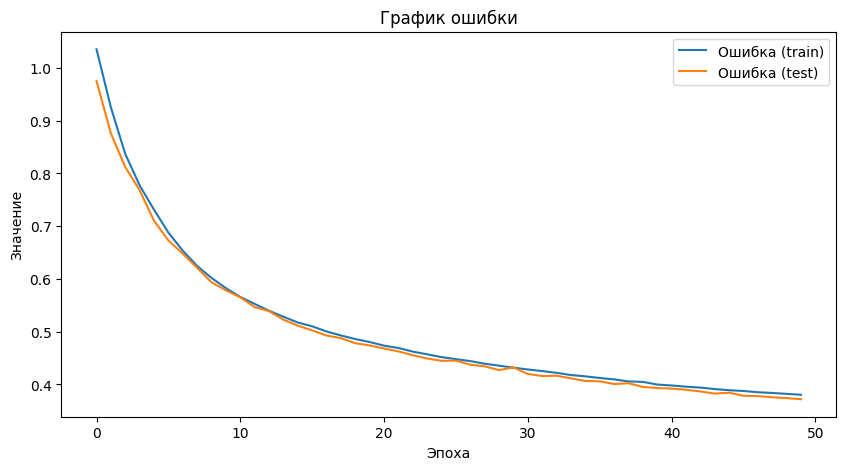

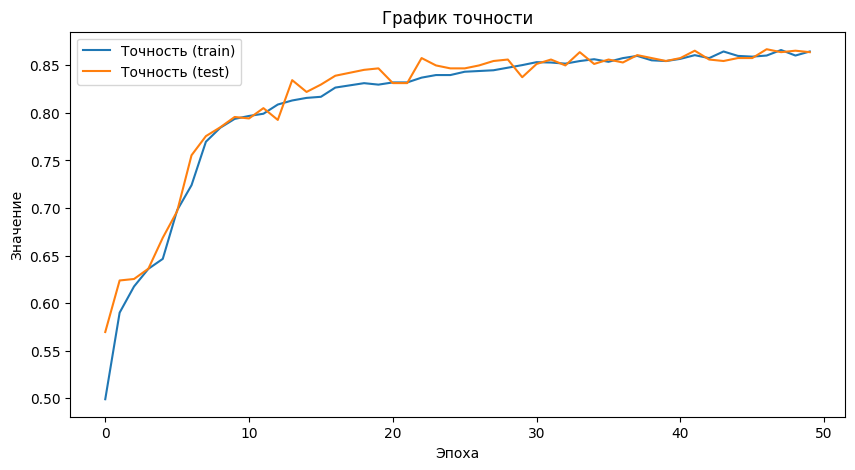

In [20]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)'])

plt.figure(1, figsize=(10,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)'])

Вывол метрик для полной модели

In [21]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Loss: 0.3716900944709778
Accuracy: 0.8637771010398865
F1: 0.7315707206726074
Precision: 0.5817657709121704
Recall: 0.9866071343421936


Вывод метрик для каждой модели с отсутствующем признаком

In [22]:
acc = {}
for feature in X.columns:
    X_test_zero = X_test.copy(True)
    X_train_zero = X_train.copy(True)
    zero_feature_test = X_test_zero[feature].values[:] = 0
    zero_feature_train = X_train_zero[feature].values[:] = 0
    X_test_zero[feature] = zero_feature_test
    X_train_zero[feature] = zero_feature_train

    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)
    acc[feature] = accuracy
    print(f"For zero {feature}:")
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1_score}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print()

acc_sorted = dict(sorted(acc.items(), key=lambda item: item[1]))

For zero budget:
Loss: 0.609449565410614
Accuracy: 0.7739937901496887
F1: 0.7106848359107971
Precision: 0.6927999258041382
Recall: 0.7346230149269104

For zero revenue:
Loss: 0.6557785868644714
Accuracy: 0.7182662487030029
F1: 0.7082995176315308
Precision: 0.5633682012557983
Recall: 0.9548611640930176

For zero runtime:
Loss: 0.6711298823356628
Accuracy: 0.6811145544052124
F1: 0.6880828142166138
Precision: 0.5674998760223389
Recall: 0.875

For zero vote_average:
Loss: 0.6922162175178528
Accuracy: 0.7120742797851562
F1: 0.6675180196762085
Precision: 0.5472928285598755
Recall: 0.8576388359069824

For zero vote_count:
Loss: 0.8436247110366821
Accuracy: 0.5928792357444763
F1: 0.6310051679611206
Precision: 0.5324574112892151
Recall: 0.776289701461792



Разница в точности для каждой урезанной модели

In [23]:
for key in acc_sorted:
    print(f"{key}: {acc_sorted[key]}")

vote_count: 0.5928792357444763
runtime: 0.6811145544052124
vote_average: 0.7120742797851562
revenue: 0.7182662487030029
budget: 0.7739937901496887


Вывод: наибольшее влияние на качество работы модели оказывает число голосов, наименьшее - размер бюджета фильма

In [24]:
Y_test = Y_test.reset_index(drop=True)
predicted_row = pd.DataFrame(model.predict(X_test))
predicted = pd.DataFrame(model.predict(X_test).argmax(axis=1), columns=['predicted'])
# predicted = predicted_multilabel.replace([0, 1, 2], ["Bad", "Medium", "Good"])
predicted["real"] = pd.DataFrame(Y_test.idxmax(axis=1).values)
predicted


21/21 [==============================] - 0s 610us/step


,predicted,real
0,1,0
1,1,2
2,1,2
3,1,1
4,2,2
...,...,...
641,1,1
642,1,1
643,1,2
644,2,2


In [25]:
predicted_row

,0,1,2
0,0.527690,0.581385,0.281300
1,0.252408,0.547658,0.502910
2,0.289709,0.572622,0.465008
3,0.410632,0.559956,0.362055
4,0.064878,0.502787,0.784346
...,...,...,...
641,0.416904,0.546904,0.355584
642,0.420385,0.551175,0.353799
643,0.428631,0.556798,0.347804
644,0.148859,0.542711,0.627936


In [26]:
predicted_bool = (predicted_row.T == predicted_row.max(axis=1)).T.astype(int)
predicted_bool

,0,1,2
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1
...,...,...,...
641,0,1,0
642,0,1,0
643,0,1,0
644,0,0,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


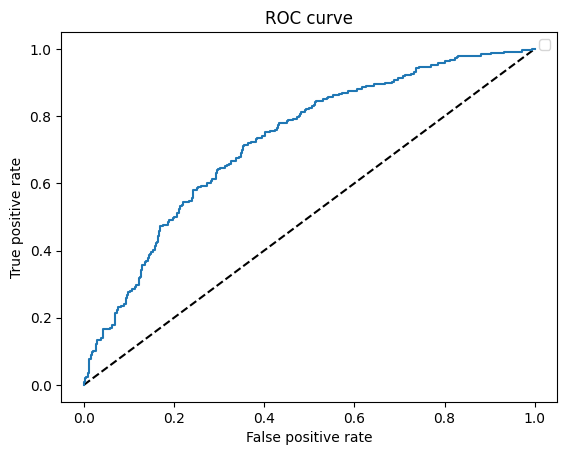

In [150]:
fpr, tpr, thresholds_keras = roc_curve(Y_test[0].values, predicted_row[0].values)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


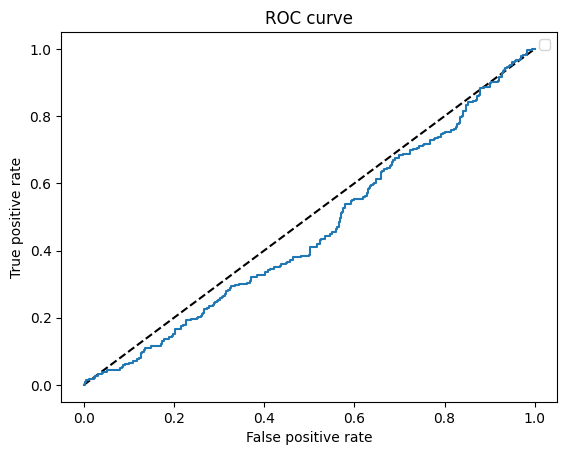

In [151]:
fpr, tpr, thresholds_keras = roc_curve(Y_test[1].values, predicted_row[1].values)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


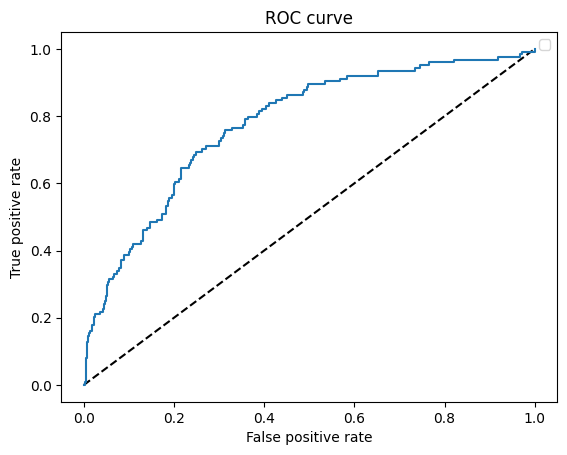

In [152]:
fpr, tpr, thresholds_keras = roc_curve(Y_test[2].values, predicted_row[2].values)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Text(0.5, 23.52222222222222, 'Prediction')

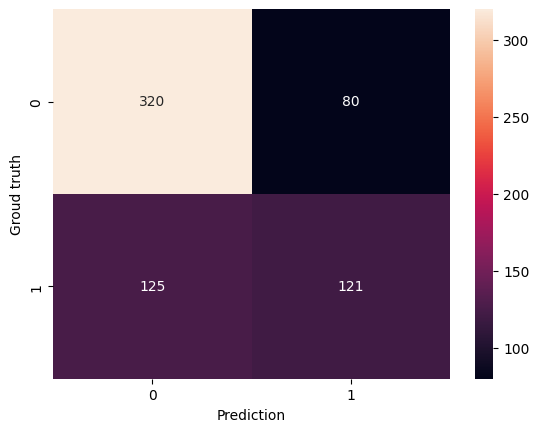

In [153]:
cm = confusion_matrix(Y_test[0], predicted_bool[0])
sb.heatmap(cm, annot=True, fmt=".5g")
plt.ylabel('Groud truth')
plt.xlabel('Prediction')

Text(0.5, 23.52222222222222, 'Prediction')

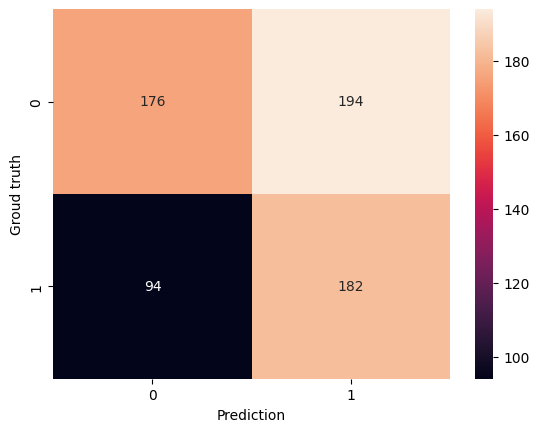

In [154]:
cm = confusion_matrix(Y_test[1], predicted_bool[1])
sb.heatmap(cm, annot=True, fmt=".5g")
plt.ylabel('Groud truth')
plt.xlabel('Prediction')

Text(0.5, 23.52222222222222, 'Prediction')

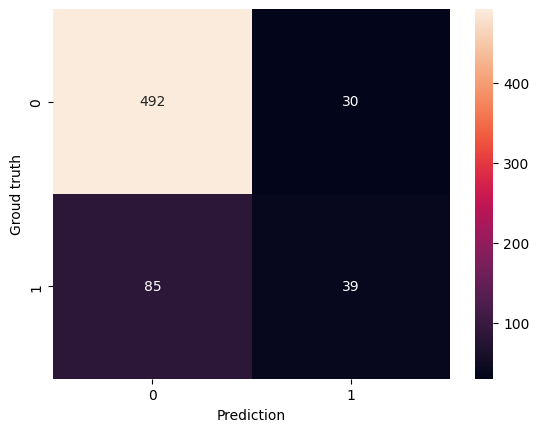

In [155]:
cm = confusion_matrix(Y_test[2], predicted_bool[2])
sb.heatmap(cm, annot=True, fmt=".5g")
plt.ylabel('Groud truth')
plt.xlabel('Prediction')

In [163]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
target_names = {
    0:'Bad',
    1:'Medium', 
    2:'Good'
}
pca_df['target'] = pd.DataFrame(Y.values.argmax(axis=1))
pca_df['target'] = pca_df['target'].map(target_names)
 
pca_df.head()

,PC1,PC2,target
0,18.949269,-6.816270,Good
1,9.310535,-1.960762,Medium
2,7.686842,-2.104783,Medium
3,8.952916,-2.657508,Good
4,3.190197,-2.239990,Medium


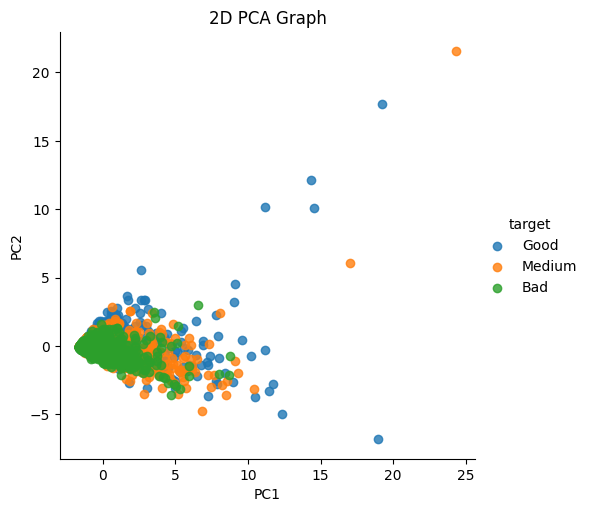

In [164]:
sb.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df, 
    hue='target', 
    fit_reg=False, 
    legend=True
    )
plt.title('2D PCA Graph')
plt.show()